In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

## 1. Wstęp

In [6]:
# file_path = "intc.csv"
# df = pd.read_csv(file_path)

# plt.figure(figsize=(13,6))
# X=df['High'][:2900]
# X_test=df['High'][2900:]
# plt.plot(X)

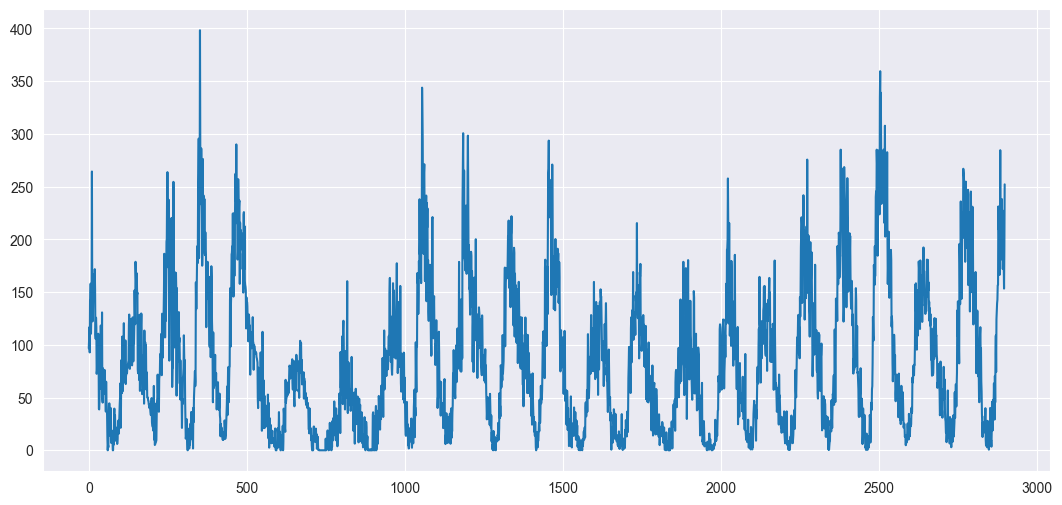

In [7]:
file_path = "Sunspots.csv"
df = pd.read_csv(file_path)

plt.figure(figsize=(13,6))
X=df['Monthly Mean Total Sunspot Number'][:2900]
X_test=df['Monthly Mean Total Sunspot Number'][2900:]
plt.plot(X)

* ACF i PACF

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


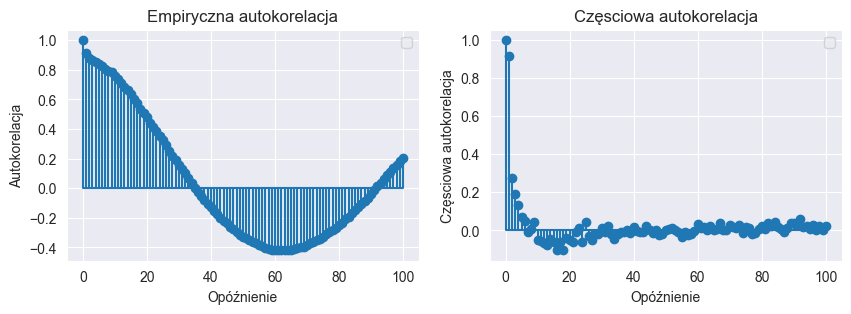

In [8]:
h_max = 100

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
acf_emp = acf(X, fft=True, nlags=h_max)
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('Empiryczna autokorelacja')
plt.legend()

plt.subplot(1, 2, 2)
acf_emp = pacf(X, nlags=h_max, method='yw')
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie')
plt.ylabel('Częsciowa autokorelacja')
plt.title('Częsciowa autokorelacja')
plt.legend()

* periodogram

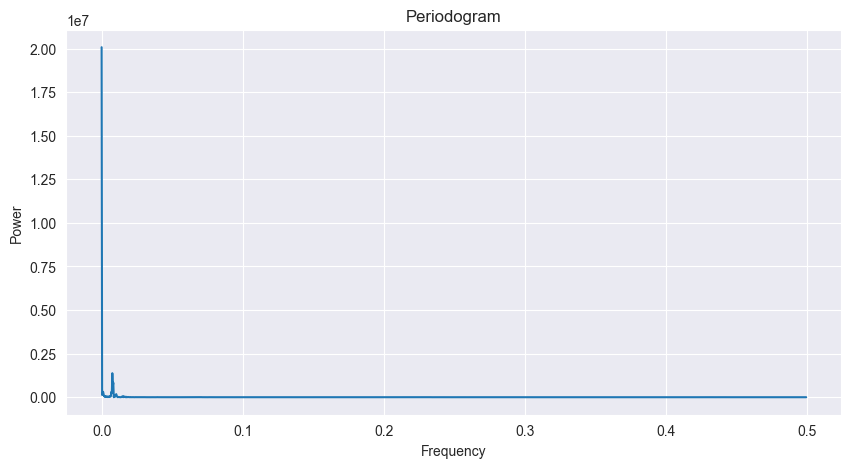

Top 5 Peaks (Frequency, Period):
Peak 1: 0.0000, inf
Peak 2: -0.0076, -131.82
Peak 3: 0.0076, 131.82
Peak 4: 0.0083, 120.83
Peak 5: -0.0083, -120.83
Peak 6: 0.0079, 126.09


C:\Users\dbjd2\AppData\Local\Temp\ipykernel_33116\2026184362.py:19: RuntimeWarning: divide by zero encountered in divide
  peaks_period = 1 / peaks_frequency


In [9]:
# Periodogram
ets_model = ExponentialSmoothing(X, seasonal_periods=130, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend

periodogram = np.abs(np.fft.fft(X-trend_ets))**2 / len(X-trend_ets)
frequencies = np.fft.fftfreq(len(X-trend_ets))

plt.figure(figsize=(10, 5))
plt.plot(frequencies[:len(X-trend_ets) // 2], periodogram[:len(X-trend_ets) // 2])
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)
plt.show()

peak_indices = np.argsort(periodogram)[::-1][:6] 
peaks_frequency = frequencies[peak_indices]
peaks_period = 1 / peaks_frequency

print("Top 5 Peaks (Frequency, Period):")
for i in range(len(peaks_frequency)):
    print(f"Peak {i+1}: {peaks_frequency[i]:.4f}, {peaks_period[i]:.2f}")

* usunięcie trendu i sezenowości

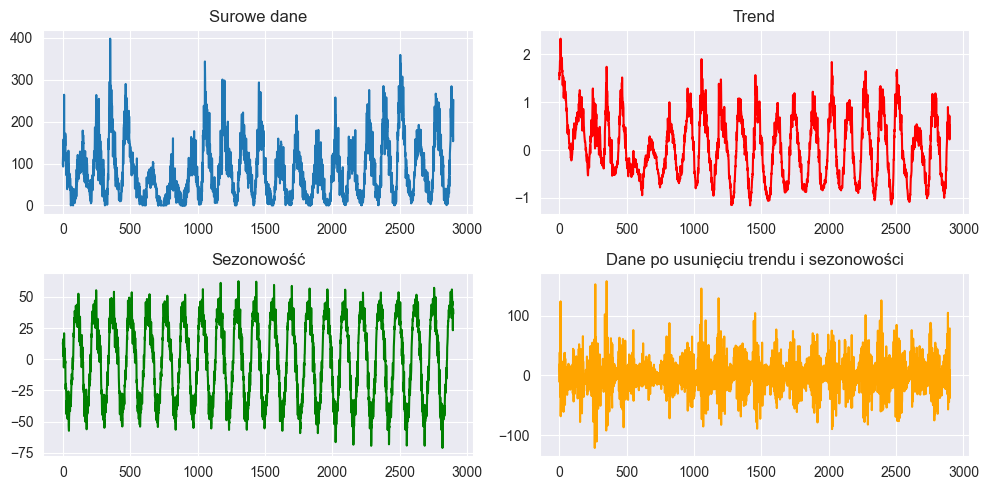

In [10]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(X, seasonal_periods=132, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(X, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green')
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

* acf dla nowego szeregu

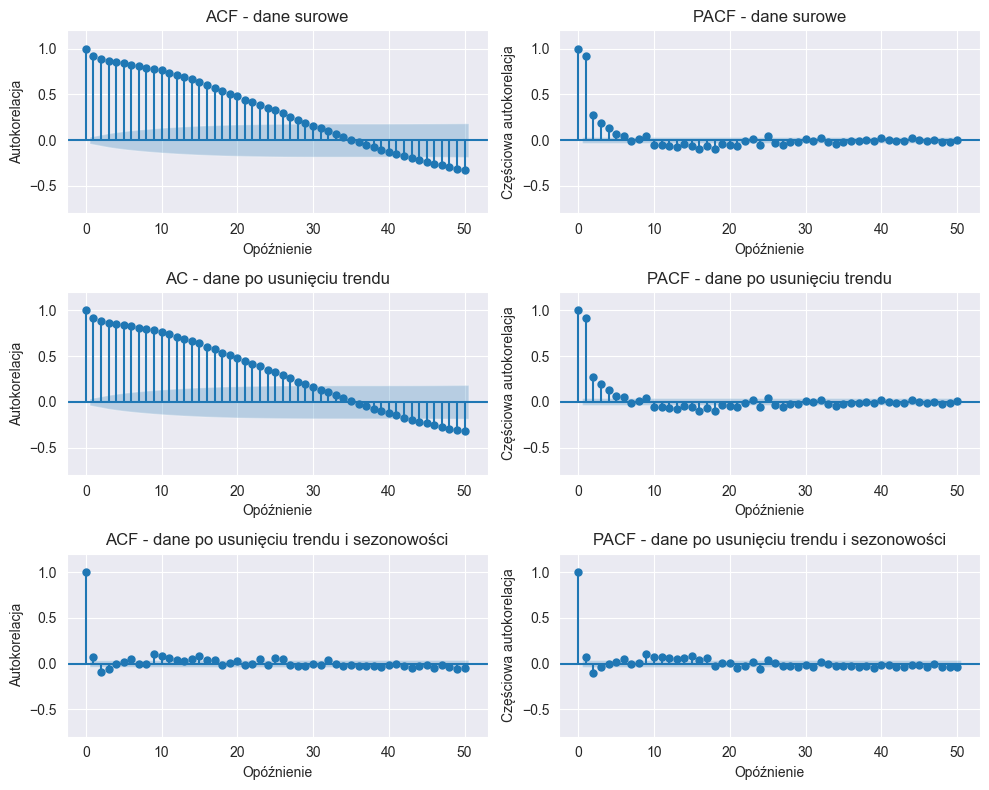

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
h_max=50

plot_acf(X, lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Opóźnienie')
axes[0, 0].set_ylabel('Autokorelacja')
axes[0, 0].set_title('ACF - dane surowe')
axes[0, 0].set_ylim(-0.8, 1.2)

plot_pacf(X, lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Opóźnienie')
axes[0, 1].set_ylabel('Częściowa autokorelacja')
axes[0, 1].set_title('PACF - dane surowe')
axes[0, 1].set_ylim(-0.8, 1.2)

plot_acf(X-trend_ets, lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Opóźnienie')
axes[1, 0].set_ylabel('Autokorelacja')
axes[1, 0].set_title('AC - dane po usunięciu trendu')
axes[1, 0].set_ylim(-0.8, 1.2)

plot_pacf(X-trend_ets, lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Opóźnienie')
axes[1, 1].set_ylabel('Częściowa autokorelacja')
axes[1, 1].set_title('PACF - dane po usunięciu trendu')
axes[1, 1].set_ylim(-0.8, 1.2)

plot_acf(residual_ets, lags=50, ax=axes[2, 0])
#axes[2, 0].plot(acf_teor_, '-', label='Teoretyczna ACF')
axes[2, 0].set_xlabel('Opóźnienie')
axes[2, 0].set_ylabel('Autokorelacja')
axes[2, 0].set_title('ACF - dane po usunięciu trendu i sezonowości')
axes[2, 0].set_ylim(-0.8, 1.2)

plot_pacf(residual_ets, lags=50, ax=axes[2, 1])
#axes[2, 1].plot(pacf_teor_, '-', label='Teoretyczna PACF')
axes[2, 1].set_xlabel('Opóźnienie')
axes[2, 1].set_ylabel('Częściowa autokorelacja')
axes[2, 1].set_title('PACF - dane po usunięciu trendu i sezonowości')
axes[2, 1].set_ylim(-0.8, 1.2)

plt.tight_layout()
plt.show()

## 3. Modelowanie przy pomocy modelu ARMA

* rząd modelu - kryterium informacyjne

In [12]:
df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 5
max_q = 5

for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(residual_ets, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

In [13]:
df.sort_values(by='AIC').head(1)


,p,q,AIC,BIC,HQIC
17,3,2,27105.497684,27147.304946,27120.561598


In [14]:
df.sort_values(by='BIC').head(1)


,p,q,AIC,BIC,HQIC
17,3,2,27105.497684,27147.304946,27120.561598


In [15]:
df.sort_values(by='HQIC').head(1)

,p,q,AIC,BIC,HQIC
17,3,2,27105.497684,27147.304946,27120.561598


 !!!!! Pytanie czy z tych tabelek wyżej wynika ze model to ARMA (2,1)?

* estymacja parametrów

In [16]:
p, q = 3, 2

model = ARIMA(residual_ets, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2900
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13594.677
Date:                Sat, 25 Jan 2025   AIC                          27203.355
Time:                        16:48:58   BIC                          27245.162
Sample:                             0   HQIC                         27218.419
                               - 2900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0577      0.485     -0.119      0.905      -1.007       0.892
ar.L1          0.5909      0.460      1.284      0.199      -0.311       1.493
ar.L2         -0.4283      0.204     -2.103 

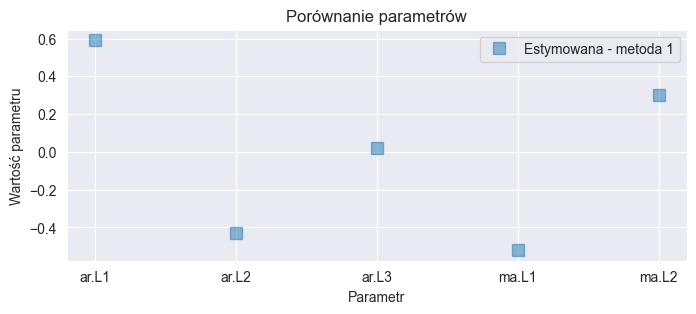

In [17]:
plt.figure(figsize=(8,3))


plt.plot(model.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')

plt.show()

In [20]:

model_first_method = ARIMA(residual_ets, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(residual_ets, order=(p, 0, q)).fit(method='innovations_mle')
# model_third_method = ARIMA(residual_ets, order=(p, 0, q)).fit(method='hannan_rissanen')

print("Wyniki dla method='statespace':\n")
print(model_first_method.summary())
print("\n")
print("Wyniki dla method='innovations_mle':\n")
print(model_second_method.summary())
print("\n")
# print("Wyniki dla method='hannan_rissanen':\n")
# print(model_third_method.summary())

Wyniki dla method='statespace':

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2900
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13545.749
Date:                Sat, 25 Jan 2025   AIC                          27105.498
Time:                        16:53:11   BIC                          27147.305
Sample:                             0   HQIC                         27120.562
                               - 2900                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0488      0.864     -0.056      0.955      -1.742       1.644
ar.L1          1.8391      0.028     65.324      0.000       1.784       1.894
ar.L2         -1.01

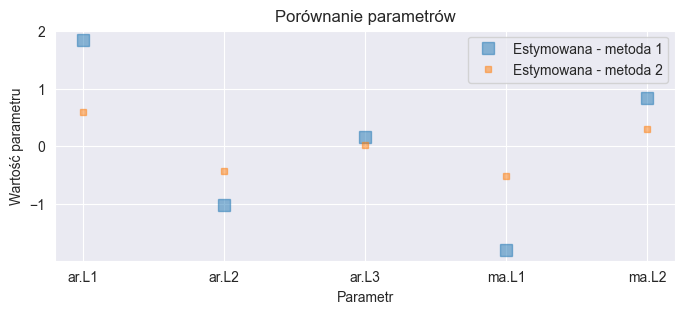

In [21]:
plt.figure(figsize=(8,3))
plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
# plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')

plt.show()

## 4. Ocena dopasowania modelu

* pzredziały ufności dla ACF/PACF

In [22]:
print(model.params)

const      -0.057668
ar.L1       0.590921
ar.L2      -0.428322
ar.L3       0.022839
ma.L1      -0.520939
ma.L2       0.299170
sigma2    690.731468
dtype: float64


!!!! czym jest const???? w tym wyzej

!!! czy ja wgl dobrze tu generuje? :<

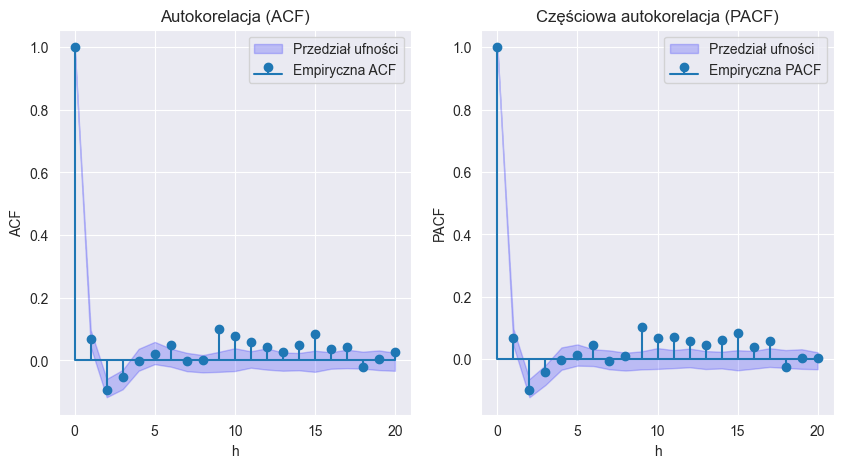

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf

# Parametry
n = 100
alfa = 0.05

# Dane wejściowe
wektor_h = list(range(21))
h_max = len(wektor_h) - 1

# Definicja parametrów ARMA
ar_coef = np.r_[1, -model.params[1:4]]  # AR zaczyna się od 1, odwrotność znaków
ma_coef = np.r_[1, model.params[4:6]]     # MA zaczyna się od 1
sigma_sq = np.sqrt(model.params[6])     # Skala to odchylenie standardowe

arma_process = ArmaProcess(ar_coef, ma_coef)

# Tablice do przechowywania wyników
lista_acf = np.zeros((n, h_max + 1))
lista_pacf = np.zeros((n, h_max + 1))

# Symulacja trajektorii i obliczenie ACF/PACF
for i in range(n):
    arma_process_trajectory = arma_process.generate_sample(nsample=len(X), scale=sigma_sq)
    lista_acf[i, :] = acf(arma_process_trajectory, fft=True, nlags=h_max)
    lista_pacf[i, :] = pacf(arma_process_trajectory, nlags=h_max, method='yw')

# Wyznaczanie przedziałów kwantylowych
lower_acf = np.quantile(lista_acf, alfa, axis=0)
upper_acf = np.quantile(lista_acf, 1 - alfa, axis=0)

lower_pacf = np.quantile(lista_pacf, alfa, axis=0)
upper_pacf = np.quantile(lista_pacf, 1 - alfa, axis=0)

# Empiryczne ACF i PACF
acf_emp = acf(residual_ets, fft=True, nlags=h_max)
# pacf_emp = pacf(X, nlags=h_max, method='yw')
pacf_emp = pacf(residual_ets, nlags=h_max, method='yw')


# Wykresy ACF
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.stem(wektor_h, acf_emp, basefmt='', label='Empiryczna ACF')
plt.fill_between(wektor_h, lower_acf, upper_acf, color="blue", alpha=0.2, label='Przedział ufności')
plt.xlabel("h")
plt.ylabel("ACF")
plt.title("Autokorelacja (ACF)")
plt.legend()

plt.subplot(1,2,2)
plt.stem(wektor_h, pacf_emp, basefmt='', label='Empiryczna PACF')
plt.fill_between(wektor_h, lower_pacf, upper_pacf, color="blue", alpha=0.2, label='Przedział ufności')
plt.xlabel("h")
plt.ylabel("PACF")
plt.title("Częściowa autokorelacja (PACF)")
plt.legend()
plt.show()



* trajketorie kwantylowe

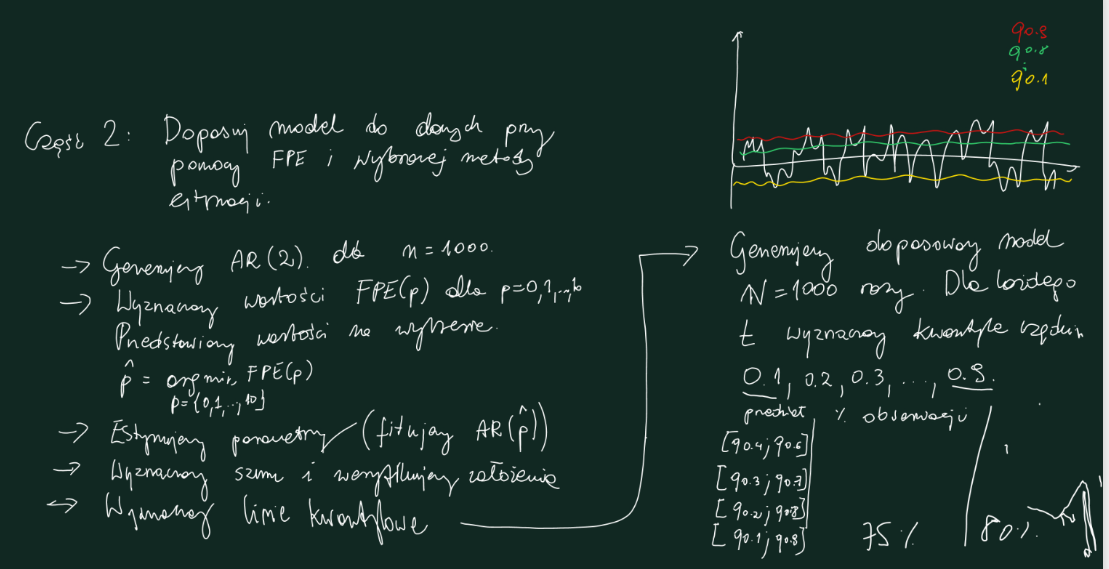

!!! tego tez nie jestem pewna :(( tego nizej

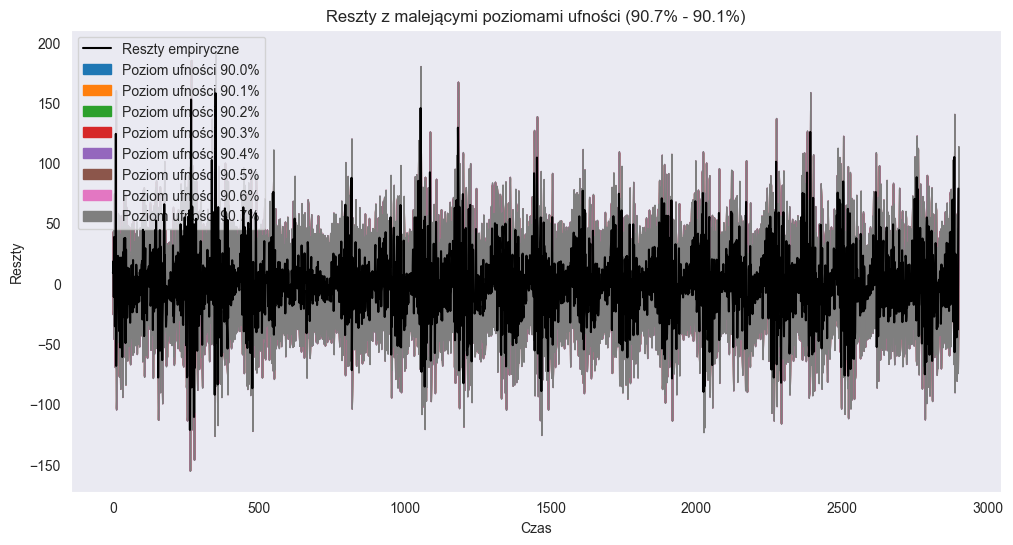

In [24]:
# Parametry symulacji
N = 1000  # Liczba symulacji
n_obs = len(X)  # Liczba obserwacji w każdej symulacji
quantile_levels = np.arange(0.900, 0.907,0.001)  # Malejące poziomy kwantyli od 90.7% do 90.1%

# Parametry modelu ARMA
ar_coef = np.r_[1, -model.params[1:4]]  # AR (odwrócone znaki)
ma_coef = np.r_[1, model.params[4:6]]     # MA
sigma_sq = np.sqrt(model.params[6])     # Odchylenie standardowe

arma_process = ArmaProcess(ar_coef, ma_coef)

# Tablica do przechowywania reszt
residuals_matrix = np.zeros((N, n_obs))

# Generowanie trajektorii i obliczanie reszt
for i in range(N):
    simulated_data = arma_process.generate_sample(nsample=n_obs, scale=sigma_sq)
    residuals_matrix[i, :] = residual_ets - simulated_data

# Wizualizacja z różnymi przedziałami ufności
plt.figure(figsize=(12, 6))
plt.plot(np.arange(n_obs), residual_ets, label='Reszty empiryczne', color='black', zorder=10)

# Iteracja po poziomach kwantyli
for i, q in enumerate(quantile_levels):
    lower_bound = np.quantile(residuals_matrix, q, axis=0)  # Dolny kwantyl
    upper_bound = np.quantile(residuals_matrix, 1 - q, axis=0)  # Górny kwantyl
    plt.fill_between(
        np.arange(n_obs),
        lower_bound,
        upper_bound,  # Stała przezroczystość
        label=f"Poziom ufności {round(q * 100, 1)}%",
        color=f"C{i}"  # Automatyczny wybór koloru (C0, C1, itd.)
    )

# Dodanie szczegółów wykresu
plt.xlabel("Czas")
plt.ylabel("Reszty")
plt.title("Reszty z malejącymi poziomami ufności (90.7% - 90.1%)")
plt.legend()
plt.grid()
plt.show()





* prognoza  - POMIJAMY CHYBA


In [25]:
def func2(wektor_t,b_1,b_2,b_3):
    return b_1*np.sin(b_2*wektor_t)+b_3
n=len(X)
wektor_t=np.linspace(0,n,n)
popt, pcov = curve_fit(func2,wektor_t,seasonal_ets,p0=[100,30,0])
b1_hat,b2_hat, b3_hat=popt
X_3=seasonal_ets-b1_hat*np.sin(wektor_t*b2_hat)-b3_hat

In [26]:
def func1(wektor_t,a_1,a_2,a_3):
    return a_1*np.log(wektor_t)+a_3

n=len(X)
wektor_t=np.linspace(1,n,n)
popt, pcov = curve_fit(func1,wektor_t,trend_ets)
a1_hat,a2_hat, a3_hat=popt
X_2=trend_ets-a1_hat*np.log(wektor_t)-a3_hat

c:\Users\dbjd2\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Text(0.5, 1.0, 'dane X')

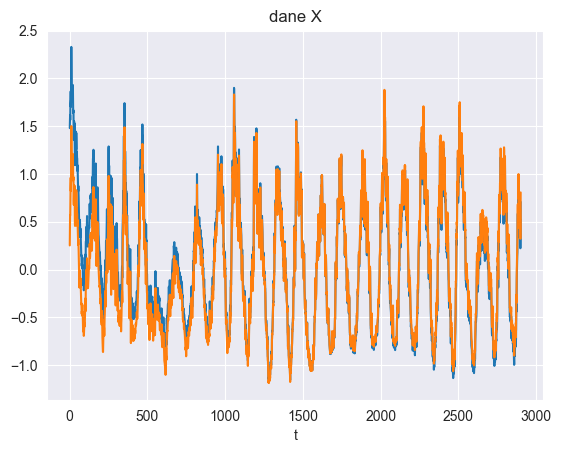

In [27]:
plt.plot(wektor_t,trend_ets)
plt.plot(wektor_t,X_2)
plt.xlabel('t')
plt.title('dane X')

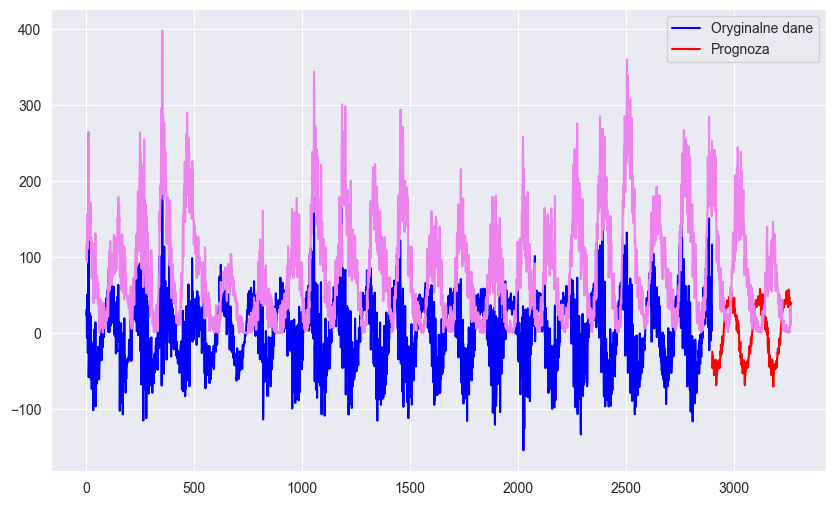

In [28]:

# 2. Dopasowanie modelu ARMA(1,2) do komponentu resztowego
arma_model = ARIMA(residual_ets.dropna(), order=(1, 0, 2))  # d=0, bo modelujesz resztę
arma_fit = arma_model.fit()

n_steps = len(X_test) # Liczba kroków do prognozy
residual_forecast = arma_fit.forecast(steps=n_steps)


future_trend = trend_ets[-n_steps:]  # Ekstrapolacja trendu (lub dopasowanie)
future_seasonal = seasonal_ets[-n_steps:]  # Powtórzenie sezonowości (lub odpowiednia predykcja)

final_forecast = future_trend.values + future_seasonal.values + residual_forecast

plt.figure(figsize=(10, 6))
plt.plot(trend_ets + seasonal_ets + residual_ets, label='Oryginalne dane', color='blue')
plt.plot(final_forecast, label='Prognoza', color='red')
plt.plot(X_test,color='violet')
plt.plot(X,color='violet')
plt.legend()
plt.show()


## 5. Weryfikacja założeń szumu

* residua modelu

Średnia: 0.0005621846132668774


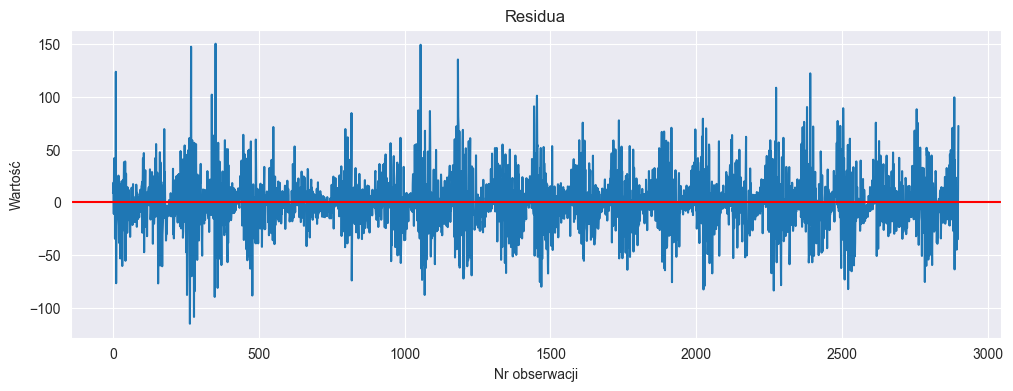

In [29]:
# Wyznaczanie residuów na podstawie dopasowanego modelu
resid_normal =model.resid
print("Średnia:",np.mean(resid_normal))

plt.figure(figsize=(12, 4))
plt.plot(resid_normal)
plt.title('Residua')
plt.xlabel('Nr obserwacji')
plt.ylabel('Wartość')
plt.axhline(y=0,color='red')
plt.show()

* wariancja 

In [30]:
import numpy as np
from scipy.stats import levene

groups = np.array_split(resid_normal, 3)  # Podział na 3 grupy (równej wielkości)

# Wykonaj test Levene'a
stat, p_value = levene(*groups)

print("Levene's test statistic:", stat)
print("p-value:", p_value)

if p_value < 0.01:
    print("Odrzucamy hipotezę zerową: wariancje nie są równe.")
else:
    print("Nie odrzucamy hipotezy zerowej: wariancje są równe.")


Levene's test statistic: 7.244116953336479
p-value: 0.000727379079384103
Odrzucamy hipotezę zerową: wariancje nie są równe.


* niezależność

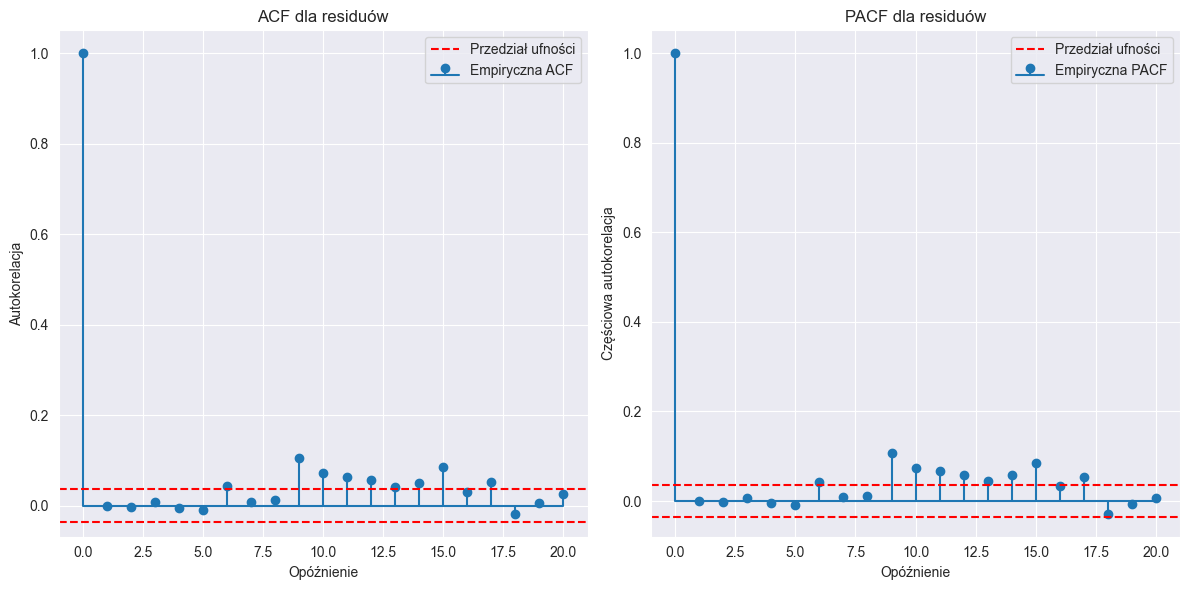

In [31]:

from scipy.stats import norm  # Do wyznaczenia kwantyli

# Dane przykładowe (podmień swoimi danymi)
# resid_normal = ...  # Twoje dane
# h_max = ...         # Maksymalne opóźnienie
N = len(resid_normal)  # Liczba obserwacji

# Obliczenie ACF i PACF
acf_emp = acf(resid_normal, fft=True, nlags=h_max)
acf_emp_t = pacf(resid_normal, nlags=h_max, method='yw')

# Wyznaczenie poziomu ufności (95%)
alpha = 0.05
lower_quantile = norm.ppf(alpha / 2)  # Dolny kwantyl
upper_quantile = norm.ppf(1 - alpha / 2)  # Górny kwantyl

# Granice przedziałów ufności
conf_int_acf = upper_quantile / np.sqrt(N)  # Dla ACF
conf_int_pacf = upper_quantile / np.sqrt(N)  # Dla PACF

# Wykresy
plt.figure(figsize=(12, 6))

# Wykres ACF
plt.subplot(1, 2, 1)
plt.stem(range(len(acf_emp)), acf_emp, basefmt='', label='Empiryczna ACF')
plt.axhline(y=conf_int_acf, color='r', linestyle='--', label='Przedział ufności')
plt.axhline(y=-conf_int_acf, color='r', linestyle='--')
plt.xlabel('Opóźnienie')
plt.ylabel('Autokorelacja')
plt.title('ACF dla residuów')
plt.legend()

# Wykres PACF
plt.subplot(1, 2, 2)
plt.stem(range(len(acf_emp_t)), acf_emp_t, basefmt='', label='Empiryczna PACF')
plt.axhline(y=conf_int_pacf, color='r', linestyle='--', label='Przedział ufności')
plt.axhline(y=-conf_int_pacf, color='r', linestyle='--')
plt.xlabel('Opóźnienie')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla residuów')
plt.legend()

plt.tight_layout()
plt.show()



* normalność rozkładu

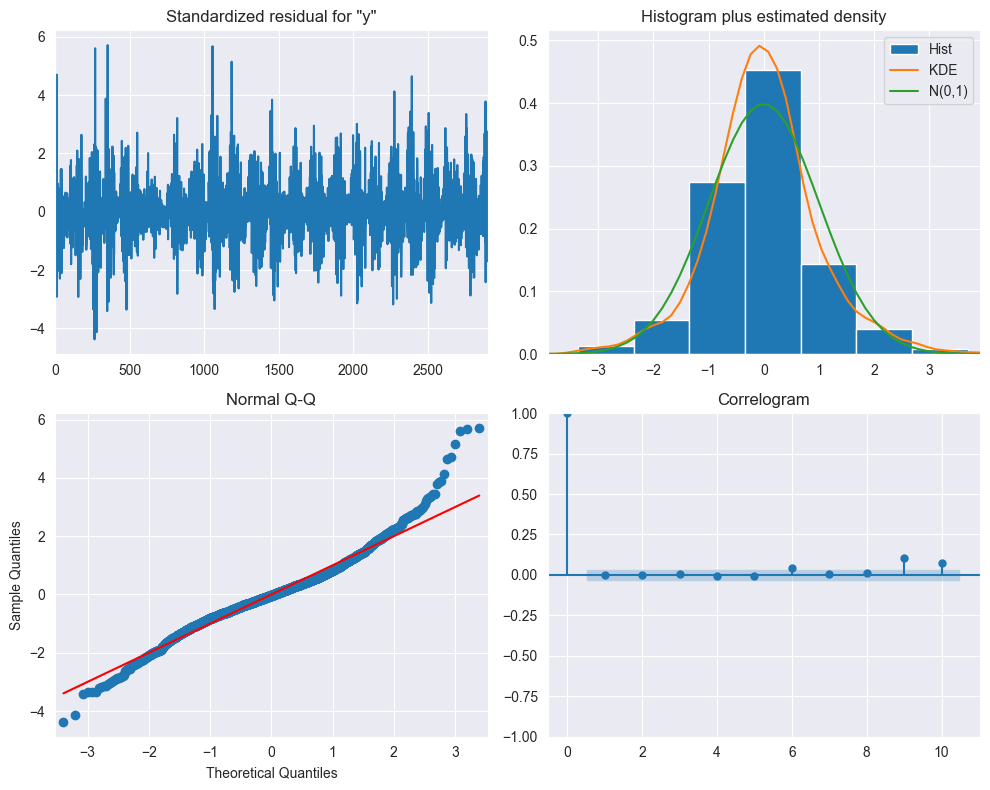

In [32]:
model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()